# Sentiment analysis on IMDB reviews: TensorFlow GloVe and LSTM with Estimator APIs

In this notebook I will try to perform sentiment analysis using TensorFlow. Most of the notebook is a variation of what was done on this blog:
https://www.oreilly.com/learning/perform-sentiment-analysis-with-lstms-using-tensorflow

This is an upgrade of the previous notebook (IMDB_sent_an_TF_basic_improved1) where I'm replacing the basic APIs by custom Estimator level APIs. For this I follow the indications of these tutorial:

https://www.tensorflow.org/get_started/premade_estimators

https://www.tensorflow.org/get_started/datasets_quickstart

https://www.tensorflow.org/get_started/custom_estimators


## Libraries

In [2]:
import numpy as np
import csv
import io
import tensorflow as tf

## Loading pretrained embeddings

The pretrained embeddins from GloVe can be downloaded here: https://nlp.stanford.edu/projects/glove/

In this notebook, I use the smallest ones, i.e. the ones where the word embedding vectors are of length 50.

In [3]:
#emb_file_name = 'glove.6B/glove.6B.50d_toy.txt' #toy embeddings with only the
                                                #three first rows (instead of 4K)
emb_file_name = 'glove.6B/glove.6B.50d.txt'

The code of the next cell comes from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python#45894001

In [4]:
import pandas as pd
import csv

emb_df = pd.read_table(emb_file_name, sep=" ",
                       index_col=0, header=None, quoting=csv.QUOTE_NONE, encoding='utf-8')

In [5]:
emb_df.shape

(400000, 50)

Then we transform the Pandas data frame into one list containing the words (the indexes from the data frame) and one numpy array containing the corresponding vectors.

In [6]:
wordsList = list(emb_df.index)
wordVectors = emb_df.values

In [7]:
type(wordVectors)

numpy.ndarray

In [8]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


## Examples with Embeddings

In [9]:
baseballIndex = wordsList.index('baseball')
wordVectors[baseballIndex]

array([-1.9327  ,  1.0421  , -0.78515 ,  0.91033 ,  0.22711 , -0.62158 ,
       -1.6493  ,  0.07686 , -0.5868  ,  0.058831,  0.35628 ,  0.68916 ,
       -0.50598 ,  0.70473 ,  1.2664  , -0.40031 , -0.020687,  0.80863 ,
       -0.90566 , -0.074054, -0.87675 , -0.6291  , -0.12685 ,  0.11524 ,
       -0.55685 , -1.6826  , -0.26291 ,  0.22632 ,  0.713   , -1.0828  ,
        2.1231  ,  0.49869 ,  0.066711, -0.48226 , -0.17897 ,  0.47699 ,
        0.16384 ,  0.16537 , -0.11506 , -0.15962 , -0.94926 , -0.42833 ,
       -0.59457 ,  1.3566  , -0.27506 ,  0.19918 , -0.36008 ,  0.55667 ,
       -0.70315 ,  0.17157 ])

In [10]:
maxSeqLength = 10 #Maximum length of sentence

In [11]:
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
#firstSentence[8] and firstSentence[9] are going to be 0
print(firstSentence.shape)
print(firstSentence) #Shows the row index for each word

(10,)
[   41   804     0  1005    15  7446     5 13767     0     0]


In [12]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)

(10, 50)


## Visualizing the data

In this section we are looking for the threshold we should take as maximum length of a text.

In [13]:
from os import listdir
from os.path import isfile, join

In [14]:
PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb/"
#PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb_sample2/"
TRAIN = PATH+'train/'
TEST = PATH+'test/'

In [15]:
TRAIN_POS = TRAIN + 'pos/'
TRAIN_NEG = TRAIN + 'neg/'
positiveFilesTrain = [TRAIN_POS + f for f in listdir(TRAIN_POS) if isfile(join(TRAIN_POS, f))]
negativeFilesTrain = [TRAIN_NEG + f for f in listdir(TRAIN_NEG) if isfile(join(TRAIN_NEG, f))]

In [16]:
TEST_POS = TEST + 'pos/'
TEST_NEG = TEST + 'neg/'
positiveFilesTest = [TEST_POS + f for f in listdir(TEST_POS) if isfile(join(TEST_POS, f))]
negativeFilesTest = [TEST_NEG + f for f in listdir(TEST_NEG) if isfile(join(TEST_NEG, f))]

Next we determine the average number of words in one sample of the training set.

In [17]:
numWords = []
for pf in positiveFilesTrain:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFilesTrain:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

Positive files finished
Negative files finished


In [18]:
numFilesTrain = len(positiveFilesTrain) + len(negativeFilesTrain)
numFilesTest = len(positiveFilesTest) + len(negativeFilesTest)

Strangely it seems that there aren't exactly 12500 files in the folders indicated below, as it is supposed to be.

In [19]:
print(len(positiveFilesTrain))
print(len(negativeFilesTrain))
print(len(positiveFilesTest))
print(len(negativeFilesTest))

12501
12501
12501
12500


In [20]:
print('The total number of files is', numFilesTrain)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

The total number of files is 25002
The total number of words in the files is 5844682
The average number of words in the files is 233.7685785137189


Next we plot an histogram of the number of words in each sample.

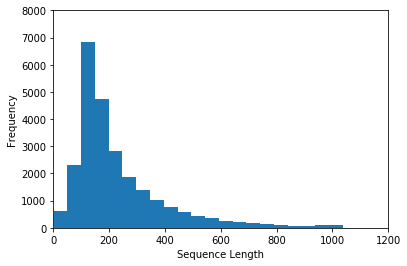

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

Looking at this, 250 seems a good choice.

In [22]:
maxSeqLength = 250

## Mapping words to indexes

In this section we map words to indexes using our wordsList variable.

First we do it for a specific file.

In [23]:
fname = positiveFilesTrain[3] #Can use any valid index (not just 3)
with open(fname) as f:
    for lines in f:
        print(lines)
        exit

An excellent movie about two cops loving the same woman. One of the cop (Périer) killed her, but all the evidences seems to incriminate the other (Montand). The unlucky Montand doesnt know who is the other lover that could have killed her, and Périer doesnt know either that Montand had an affair with the girl. Montand must absolutely find the killer...and what a great ending! Highly recommended.


Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters

In [24]:
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [25]:
firstFile = np.zeros((maxSeqLength), dtype='int32')
with open(fname) as f:
    indexCounter = 0
    line=f.readline()
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
        try:
            firstFile[indexCounter] = wordsList.index(word)
        except ValueError:
            firstFile[indexCounter] = 399999 #Vector for unknown words
        indexCounter = indexCounter + 1
firstFile

array([    29,   4345,   1005,     59,     55,  12193,   8842,      0,
          215,    787,     48,      3,      0,  10417, 388445,    256,
           71,     34,     64,      0,  47019,   1348,      4,  59799,
            0,     68, 105903,      0,  20938, 105903, 136283,    346,
           38,     14,      0,     68,   8410,     12,     94,     33,
          256,     71,      5, 388445, 136283,    346,    900,     12,
       105903,     40,     29,   4160,     17,      0,   1749, 105903,
          390,   3960,    596,      0, 399999,    102,      7,    353,
         1945,   1786,   3885,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

### Training set

ids_train will be a matrix, which contains for each file of the training set (first the positive ones, then the negative ones) a row where the columns contain the indices corresponding to the words of the sample file.

In [26]:
#ids_train = np.zeros((numFilesTrain, maxSeqLength), dtype='int32')

In [27]:
#fileCounter = 0
#for pf in positiveFilesTrain:
#    with open(pf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids_train[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids_train[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1

In [28]:
#for nf in negativeFilesTrain:
#    with open(nf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids_train[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids_train[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 

In [29]:
#Pass into embedding function and see if it evaluates. 

#np.save('idsMatrixTrain', ids_train)

ids_train = np.load('idsMatrixTrain.npy')

In [30]:
print(type(ids_train))
print(ids_train.shape)
print(ids_train[0])

<class 'numpy.ndarray'>
(25002, 250)
[ 12588     14     29 399999    319     34     20     14   2242  31631
   2094  11013  17614     22     47   1058     14     20     14      7
 399999    319     42 255441     30    573    100   1299    296      0
 399999  30748      3   2838   4450  13819      0    402   4184     17
      0   4442  14959  10220      5  12588  60607  12256      0 399999
     34   2909  47119    461   4543   1749     25      0  12626   3752
      5   6801      4      0   2037   9742   1174     14  34443      5
 399999      0   3226   4260   1654    107    339     77    138     22
     58     34     20     14 130086   5610      5  16089      0  23277
   8652     42     14   7206    983     37    319     42   5635    109
    615     34   1952    306  97532   5319   2909  14014      6   2158
   5418      3      5  12534     10  12588      5      0    109     38
    593     71   9919  42692      4    155     38   1764      4    169
     20    116      0      0      0     

We create some toy data to be able to perform quick sanity check.

In [32]:
ids_train_toy = ids_train[12400:12600]
print(type(ids_train_toy))
print(ids_train_toy.shape)
print(ids_train_toy[0])

<class 'numpy.ndarray'>
(200, 250)
[  3936     48      3    192   8489   2459      0    523     14    219
   2050     14    353     64  63305    858  22181     32   2664      5
      0   5230     14  11114  10101  15951     14  11025     19   2701
  13502   3755     18     14  20355     19      0   6302  13898      5
     14   1807    143     21  12070   3992  17748  10958      5   5272
  11690     64    608  11184     32     13    389      0    319     14
 399999   1633   3496    248     60      4      4      0    156     48
      3    192   8489   1588     25      0    288   4754  10101  15951
     38     31     51      0   7255      3    359    319     18     31
   5938      6      5    907     84   3895    187     29   4345    319
     64    469      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0

### Testing set

In [30]:
#ids_test = np.zeros((numFilesTest, maxSeqLength), dtype='int32')

In [31]:
#fileCounter = 0
#for pf in positiveFilesTest:
#    with open(pf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids_test[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids_test[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1

In [32]:
#for nf in negativeFilesTest:
#    with open(nf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids_test[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids_test[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 

In [33]:
#np.save('idsMatrixTest', ids_test)

ids_test = np.load('idsMatrixTest.npy')

## Labels

Now we also create the **labels** with **one-hot-encoding** ([1, 0] for positive and [0, 1] for negative), as done in the original notebook.

In [33]:
lenPosTrain = len(positiveFilesTrain)
lenNegTrain = len(negativeFilesTrain)
y_train = [[1,0] for i in range(lenPosTrain)] + [[0,1] for i in range(lenNegTrain)]

In [34]:
lenPosTest = len(positiveFilesTest)
lenNegTest = len(negativeFilesTest)
y_test = [[1,0] for i in range(lenPosTest)] + [[0,1] for i in range(lenNegTest)]

We create the labels for the toy data.

In [49]:
y_train_toy = y_train[12400:12600]

It seems that some premade estimators do not accept one-hot-encoding of the labels as explained here:https://stackoverflow.com/questions/48114258/tensorflow-estimator-number-of-classes-does-not-change

For this reason I create a function which converts a list containing one-hot-incoded labels into a list containing **ordinal encoded** labels.

In [36]:
def oneHot2Ordinal(oneHot):
    n_classes = len(oneHot[0])
    ordinal = []
    for i in range(len(oneHot)):
        for j in range(n_classes):
            if oneHot[i][j]==1:
                ordinal.append(j)
    return(ordinal)

In [37]:
y_train_toy_ord = oneHot2Ordinal(y_train_toy)
print(len(y_train_toy_ord))
print(y_train_toy_ord[0])

200
0


In [38]:
y_train_ord = oneHot2Ordinal(y_train)
y_test_ord = oneHot2Ordinal(y_test)

## Creating batching functions

In this section we create two functions which will help feeding the model with batches of samples.

In [39]:
from random import randint

The original implementation of getTrainBatch would only use part of the training data for the training phase (indices 0 to 11498 for positive, instead of 0 to 12498, and indices 13499 to 24999 for negatives instead of 12499 to 24999). Since it is not clear exactly where the indices of the positive reviews stop and when the indices of the negative reviews start, I take stop at 12499 for positive and starts at 12502 for negative

In [40]:
def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,12499)
            labels.append([1,0])
        else:
            num = randint(12502,24999)
            labels.append([0,1])
        arr[i] = ids_train[num-1:num]
    return arr, labels

The next function is actually pretty useless. I will replace it by a function which tests the model against the whole test data (and not just against some part of the training data).

In [41]:
def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(11499,13499)
        if (num <= 12499):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids_train[num-1:num]
    return arr, labels

In [42]:
def getAllTest():
    lenPosTest = len(positiveFilesTest)
    lenNegTest = len(negativeFilesTest)
    labels = [[0,1] for i in range(lenPosTest)] + [[1,0] for i in range(lenNegTest)]
    return ids_test, labels
    

## Definition of the model

### Estimator APIs

In this section we create a model using the Estimator APIs from TF.

First we define the **input functions**. They are the objects which supply data for training, evaluating, and prediction to the model.

In [43]:
# features is a numpy array of shape (#samples, 250)
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(({'Indexes':features}, labels))

    # Shuffle, repeat, and batch the examples.
    return dataset.shuffle(1000).repeat().batch(batch_size)

If the train_input_fn works well, this **should be modified in the same way** by using a dictionary in from_tensor_slices.

In [44]:
# features is a numpy array of shape (#samples, 250)
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    if labels is None:
        # No labels, use only features.
        inputs = {'Indexes':features}
    else:
        inputs = ({'Indexes':features}, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

Next we define the **feature columns**:

In [50]:
my_feature_columns = []
my_feature_columns.append(tf.feature_column.numeric_column(key='Indexes', shape=maxSeqLength))

Next we define a **premade estimator**. This will be changed later into a custom estimator once I will have tested it and made sure that my input function and feature columns are correctly defined.

In [52]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 10 nodes each.
    hidden_units=[3, 3],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_log_step_count_steps': 100, '_task_id': 0, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpg8rlfpgj', '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efbd6511d68>, '_master': '', '_num_worker_replicas': 1, '_evaluation_master': '', '_save_summary_steps': 100, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_global_id_in_cluster': 0, '_task_type': 'worker', '_keep_checkpoint_max': 5, '_is_chief': True, '_session_config': None}


In [53]:
batch_size = int(100)
train_steps = int(1000)

Note that for the premade estimator that we are using requires the label to be ordinaly encoded and not one-hot-encoded as explained here:

https://stackoverflow.com/questions/48114258/tensorflow-estimator-number-of-classes-does-not-change

In [54]:
classifier.train(
    input_fn=lambda:train_input_fn(features=ids_train_toy, labels=y_train_toy_ord, batch_size=100),
    steps=train_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpg8rlfpgj/model.ckpt.
INFO:tensorflow:step = 1, loss = 70522.86
INFO:tensorflow:global_step/sec: 528.741
INFO:tensorflow:step = 101, loss = 65.876564 (0.190 sec)
INFO:tensorflow:global_step/sec: 874.883
INFO:tensorflow:step = 201, loss = 66.16997 (0.114 sec)
INFO:tensorflow:global_step/sec: 994.37
INFO:tensorflow:step = 301, loss = 66.38655 (0.101 sec)
INFO:tensorflow:global_step/sec: 1019.05
INFO:tensorflow:step = 401, loss = 66.679474 (0.098 sec)
INFO:tensorflow:global_step/sec: 1147.13
INFO:tensorflow:step = 501, loss = 67.04363 (0.087 sec)
INFO:tensorflow:global_step/sec: 1140.81
INFO:tensorflow:step = 601, loss = 66.09365 (0.088 sec)
INFO:tensorflow:global_step/sec: 1099.45
INFO:tensorflow:step =

### Basic APIs

In this section we present the original implementation of the model, relying on TF basic APIs. It will be replaced by estimators APIs.

In [39]:
batchSize = 24
lstmUnits = 64
numClasses = 2

In [40]:
import tensorflow as tf
tf.reset_default_graph()

These placeholders are here to take the input of the model (labels and samples turned into arrays of indices).

In [41]:
labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

Then we embed the indices into vectors. The next cell is commented out because I think that it is useless. It was in the tutorial but I suspect that its author forgot to remove it.
As explained in the tutorial, we were using pretrained embeddings where vectors have length 50. But here numDimensions are of length 300. And in the following cell, 'data' defined again... I ran the notebook with and without it and it gives similar results so I commented it out.

In [42]:
#data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)

In [43]:
data = tf.nn.embedding_lookup(wordVectors, input_data)

The following cell is a fix comming from
https://github.com/tgjeon/TensorFlow-Tutorials-for-Time-Series/issues/2
If I don't put it, errors appear in the cell after this one.

In [44]:
data = tf.cast(data, tf.float32)

Next we define the LSTM with dropout layer. According to the tutorial, the parameter lstmUnits needs some tuning to find the optimal value.

In [45]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)

Instructions for updating:
Use the retry module or similar alternatives.


If I understood it right, 'value' in the next cell represents the outputs of the lstm (for each sample of the batch and each word of each sample). According to the documentation it should have dimensions equal to [batch_size, max_time, cell.output_size].

In [46]:
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

Next we add some afine transformation.

In [47]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))

If I'm not mistaken the next cell swaps the two first dimensions so it has dimensions [max_time, batch_size, cell.output_size].

In [48]:
value = tf.transpose(value, [1, 0, 2])

If I'm not mistaken the next cell slices the part of the output which corresponds to the last output of the lstm, or in other words the output corresponding to the last word for every sample (if I'm right we used 0 padding and cut everything which goes beyound 250 words, so technically it is the 250th output). My guess is that last has dimensions [batch_size, cell.output_size] which we can then use to do matrix multiplication with weight which has dimensions [cell.output_size, numClasses] (remember that cell.output_size=lstmUnits).

In [49]:
last = tf.gather(value, int(value.get_shape()[0]) - 1)

In [50]:
prediction = (tf.matmul(last, weight) + bias)

Next we compute accuracy.

In [51]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

Next we compute the cross-entropy loss using the logits (i.e. unnormalized probabilities), and we define the optimizer. Note that I replaced tf.nn.softmax_cross_entropy_with_logits (as in the original script) by tf.nn.softmax_cross_entropy_with_logits_v2 as indicated by a warning.

In [52]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

The next cell allows us to use TensorBoard to visualize the loss and accuracy.

In [53]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

## Training

iterations gives the number of batches against whom we are going to train our model.

In [54]:
#iterations = 100000

According to the author of the tutorial I'm copying, the training takes a lot of time. For this reason, he uses a pretrained model. But he provides the (commented) code for the training, which is displayed in the next cell.

In [55]:
#sess = tf.InteractiveSession()
#saver = tf.train.Saver()
#sess.run(tf.global_variables_initializer())

In [56]:
#for i in range(iterations):
#    #Next Batch of reviews
#    nextBatch, nextBatchLabels = getTrainBatch();
#    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
#
#    #Write summary to Tensorboard
#    if (i % 50 == 0):
#        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
#        writer.add_summary(summary, i)
#
#    #Save the network every 10,000 training iterations
#    if (i % 10000 == 0 and i != 0):
#        save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
#        print("saved to %s" % save_path)
#writer.close()

## TensorBoard

The author of the tutorial also mentions the possibility of tracking the progress of the model on TensorBoard by entering "tensorboard --logdir=tensorboard" in a terminal, and visiting http://localhost:6006/ with a browser.

## Using a pretrained model

After one has trained a first time the model, one can reuse it during the next executions.

In [57]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-90000


## Testing our model on test data

To make sure one improves the quality of the model without overfitting, one has to test it agains test data. In the tutorial, they advise to alternate training phases on training data and testing phases on test data, and stop when the accuracy on test data starts decreasing.

Below we test the accuracy of the model against the whole test data.

In [58]:
n_iter_test = int(numFilesTest/batchSize)

In [89]:
lenPosTest = len(positiveFilesTest)
lenNegTest = len(negativeFilesTest)
labelsTest = [[1,0] for i in range(lenPosTest)] + [[0,1] for i in range(lenNegTest)]
accuracy_test = np.zeros(n_iter_test)

In [93]:
def getTestBatchOrder(i):
    nextBatchLabels = labelsTest[(i):(i+batchSize)]
    nextBatch = np.zeros([batchSize, maxSeqLength])
    for j in range(batchSize):
        nextBatch[j] = ids_test[(i+j):(i+j+1)]
    return nextBatch, nextBatchLabels

In [95]:
for i in range(n_iter_test):
    nextBatch, nextBatchLabels = getTestBatchOrder(i)
    accuracy_test[i] = (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100

In [97]:
print("Accuracy on test set = ", accuracy_test.mean())

Accuracy on test set =  85.53874476613275
